In [1]:
import os
import sys
import cortex
import re
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
import nibabel as nib
import pickle
import torchvision.models as models
import nibabel as nib
import h5py
import scipy.stats.mstats as mstats
import matplotlib.patches as patches
# import matplotlib.patches as mpatches
import copy
import yaml
import joblib

from nilearn import plotting
from scipy.ndimage import binary_dilation
from PIL import Image
from importlib import reload
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator, NullFormatter
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from colorama import Fore, Style
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.impute import SimpleImputer
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from tqdm import tqdm
from matplotlib.lines import Line2D
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from typing import Dict, Tuple, Union
from scipy.special import softmax
from scipy.stats import zscore as zs

print(sys.path)
%pwd

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from classes.regdata import RegData
from funcs.reloads import Reloader
from classes.natspatpred import NatSpatPred
from classes.voxelsieve import VoxelSieve

['/home/rfpred/notebooks/clean', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsd_access-0.0.1.dev0-py3.11.egg', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/cifti-1.1-py3.11.egg']


In [2]:
NSP = NatSpatPred()
NSP.initialise(verbose=True)
# importlib.reload(funcs.brain_mapping)
from funcs.brain_mapping import reg_to_nifti, vol_to_surf
rd = RegData
rl = Reloader

Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


In [3]:
rois, roi_masks, viscortex_masks = NSP.cortex.visrois_dict(verbose=False)
prf_dict = NSP.cortex.prf_dict(rois, roi_masks)

In [7]:
# Create niftis and surface files for unpredictability and encoding regressions (Takes a few minutes)
for subject in NSP.subjects:
    for this_reg in ["unpred", "encoding"]:
        model = "vgg-b" if this_reg == "unpred" else "alexnet"
        reg_to_nifti(subject=subject,
                    reg_type=this_reg,
                    model=model,
                    assign_stat="max",
                    reg_stat="delta_r",
                    plot_brain=False,
                    plot_lay_assign=False,
                    save_nifti=False)

        # vol_to_surf(subject=subject,
        #             source_file_name=f"{this_reg}_{model}_layassign_max",
        #             interpmethod="wta")

        x   y   z roi  delta_r_1  delta_r_2  delta_r_3  delta_r_4  delta_r_5  \
0      56   8  75  V1   0.245661   1.000000   0.747973   0.238047   0.000000   
1      56   9  74  V1   0.266925   1.000000   0.572369   0.093892   0.000000   
2      56   9  76  V1   0.296550   1.000000   0.779928   0.286835   0.000000   
3      56  10  75  V1   0.315516   1.000000   0.711070   0.099082   0.000000   
4      56  10  76  V1   0.276734   1.000000   0.736906   0.116823   0.000000   
...   ...  ..  ..  ..        ...        ...        ...        ...        ...   
2521  113  26  69  V4   0.385232   0.853977   0.952810   1.000000   0.618041   
2522  113  28  61  V4   0.000000   0.037436   0.248510   0.622049   1.000000   
2523  114  25  69  V4   0.421242   0.911830   0.978754   1.000000   0.597269   
2524  114  26  67  V4   0.223173   0.570871   0.847660   1.000000   0.728702   
2525  114  27  64  V4   0.204384   0.000000   0.281289   0.632047   1.000000   

      delta_r_6  Mean Weighted Layer  M

KeyboardInterrupt: 

In [22]:
# rd = rl.regdat()

TypeError: Reloader.regdat() missing 1 required positional argument: 'self'

DataFrame changed: Added the maximum layer index to the DataFrame.
DataFrame changed: Added the maximum layer index to the DataFrame.
DataFrame changed: Added the maximum layer index to the DataFrame.
DataFrame changed: Added the maximum layer index to the DataFrame.
DataFrame changed: Added the maximum layer index to the DataFrame.
DataFrame changed: Added the maximum layer index to the DataFrame.
DataFrame changed: Added the maximum layer index to the DataFrame.
DataFrame changed: Added the maximum layer index to the DataFrame.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


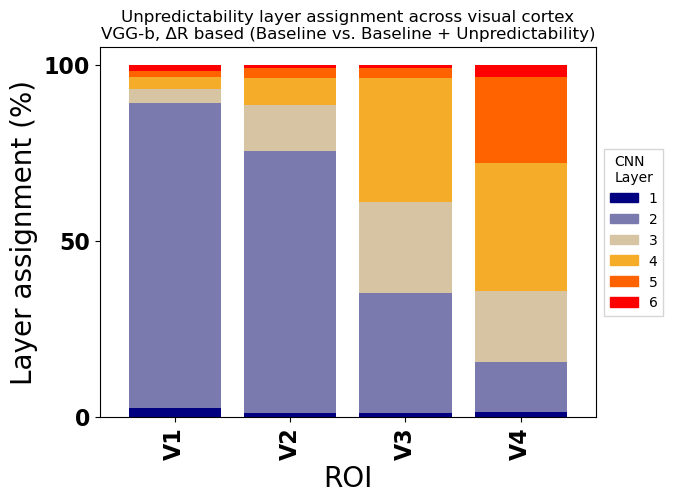

Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


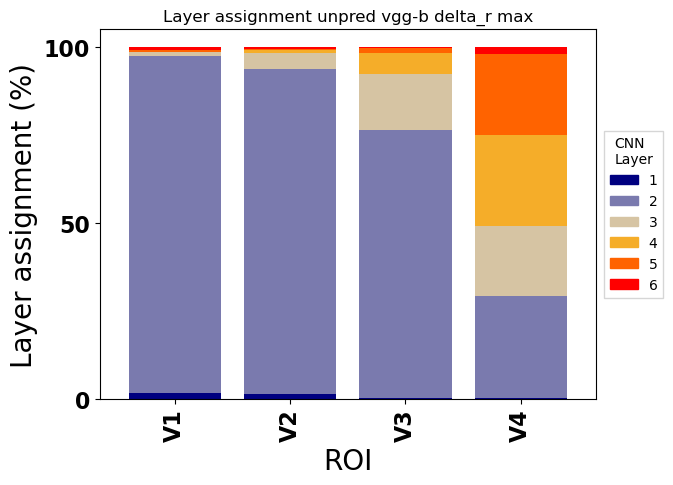

In [7]:
stacked_dfs = []

for subject in NSP.subjects:
# for subject in ["subj01"]:
    results = rd(subject = subject, folder="unpred", model="vgg-b", statistic="delta_r")

    # results._normalize_per_voxel()
    # results.assign_layers(
    #     max_or_weighted="max", 
    #     title=f"$\mathbf{{Subject\ {subject[-1]}}}$\nUnpredictability layer assignment across visual cortex\nVGG-b, ΔR based (Baseline vs. Baseline + Unpredictability)"
    # )

    results._get_max_layer()
    stacked_dfs.append(results.df)
    
final_df = pd.concat(stacked_dfs)

final_df

results.assign_layers(max_or_weighted = "max",
                      verbose = True,
                      title = "Unpredictability layer assignment across visual cortex\nVGG-b, ΔR based (Baseline vs. Baseline + Unpredictability)",
                      input_df = final_df)
    
    
results = rd(subject = "subj01", folder="unpred", model="vgg-b", statistic="delta_r")
results.assign_layers("max")


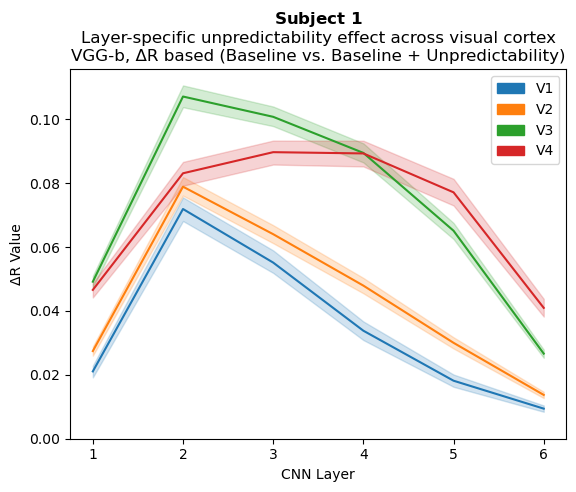

DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


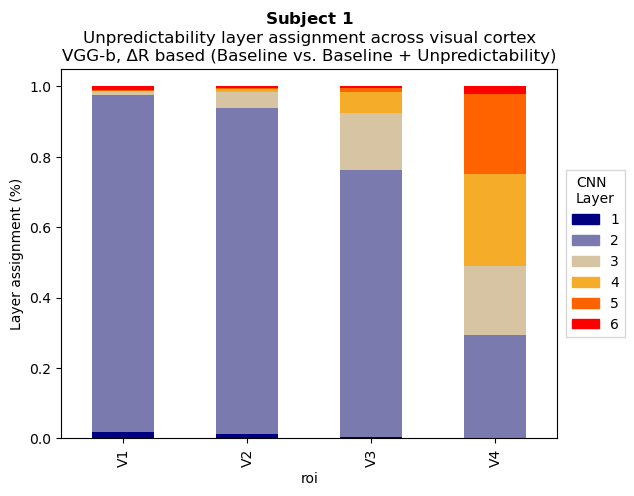

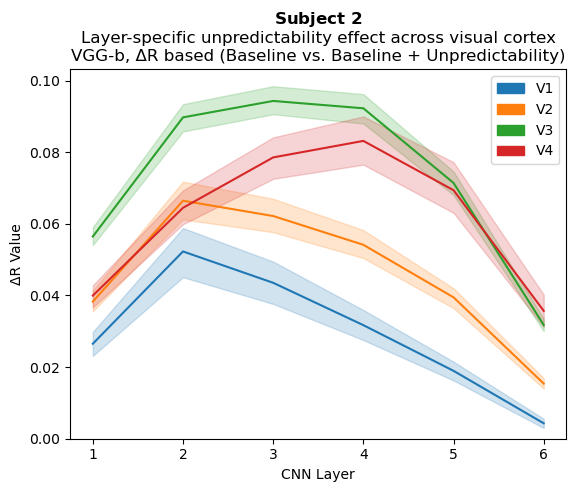

DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


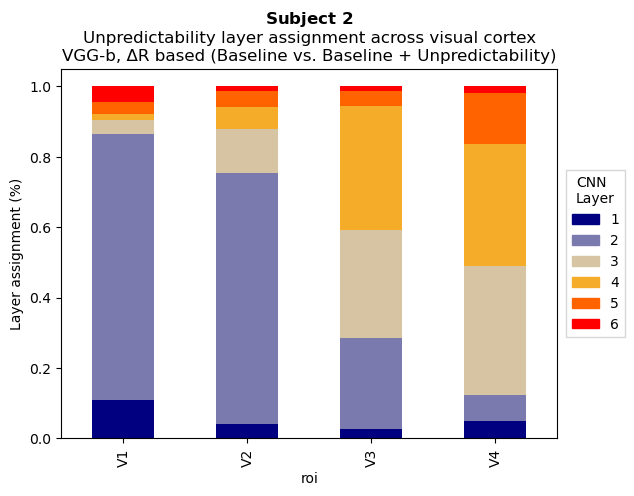

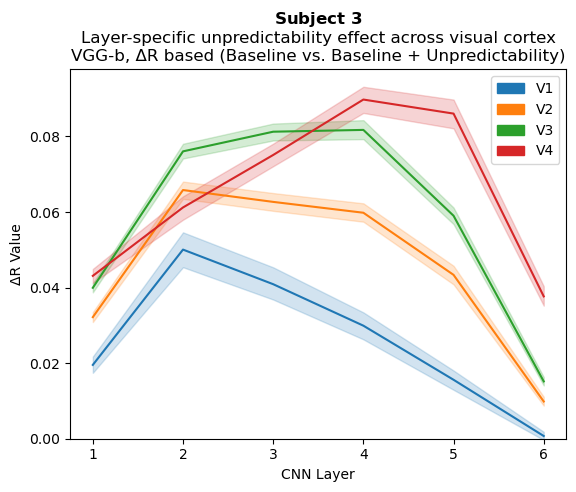

DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


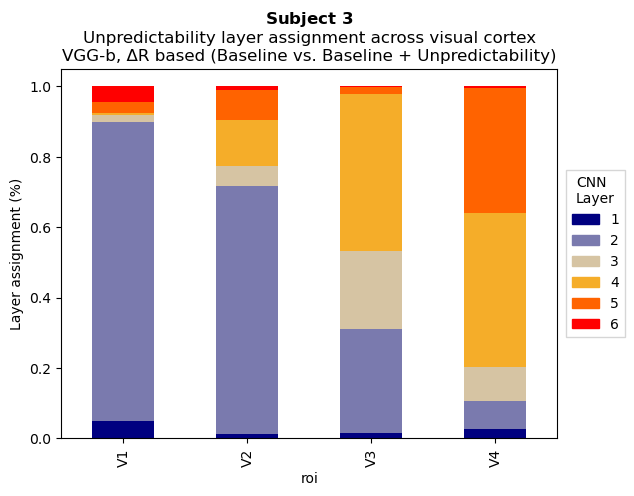

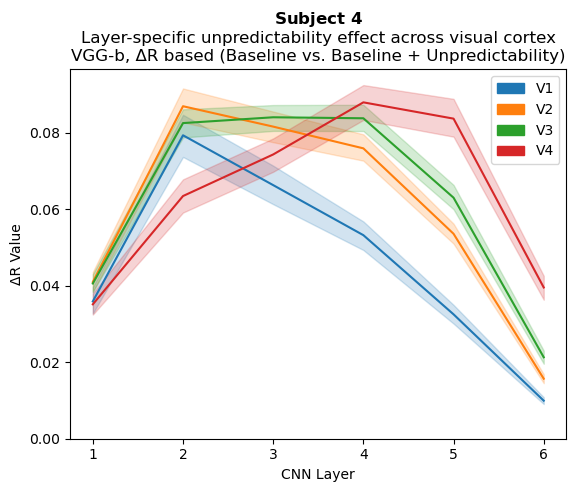

DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


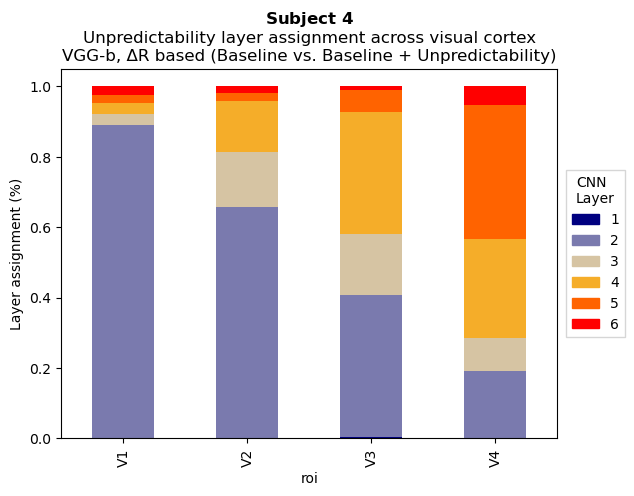

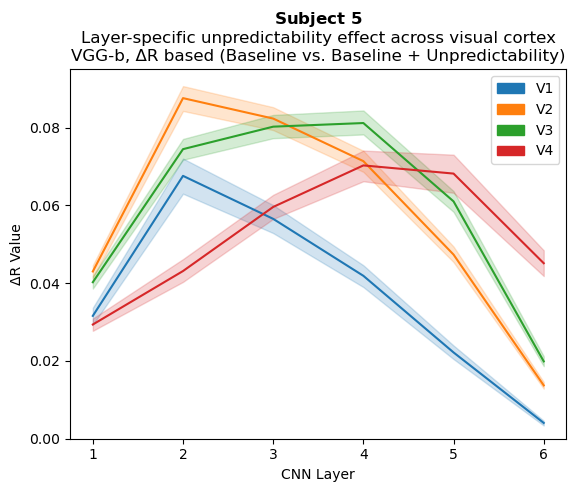

DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


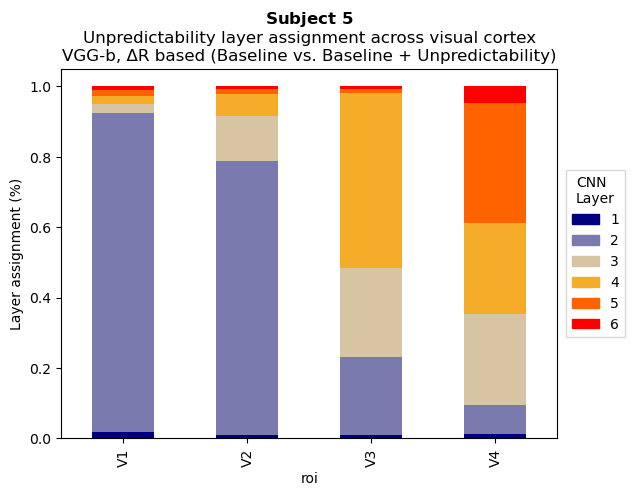

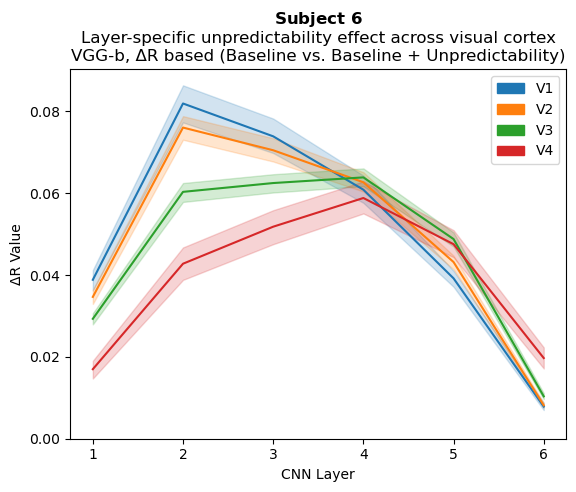

DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


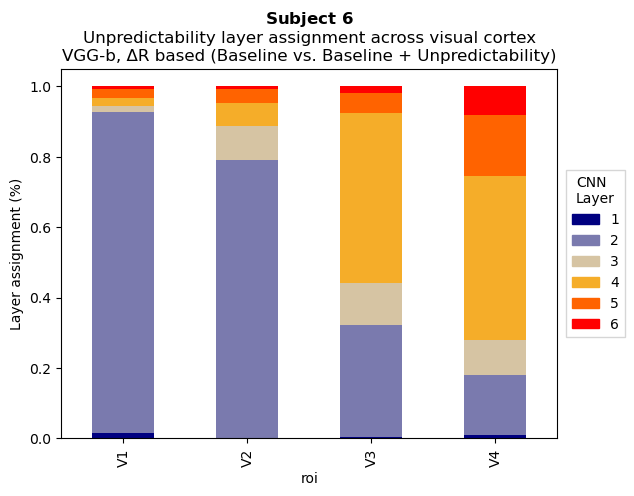

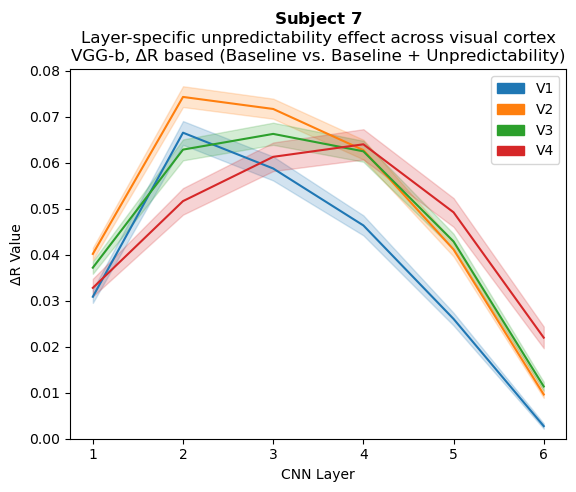

DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


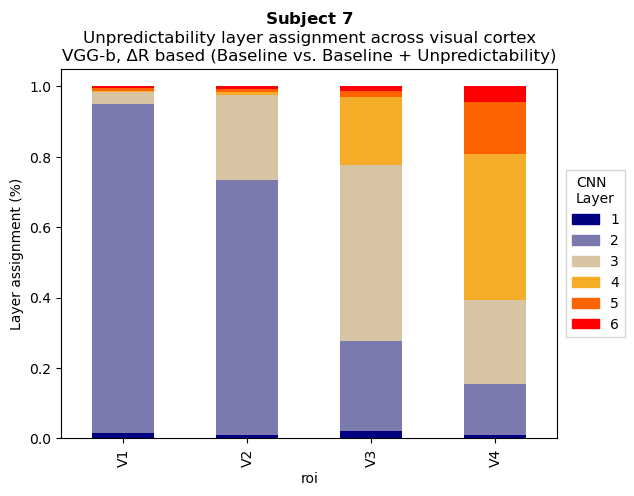

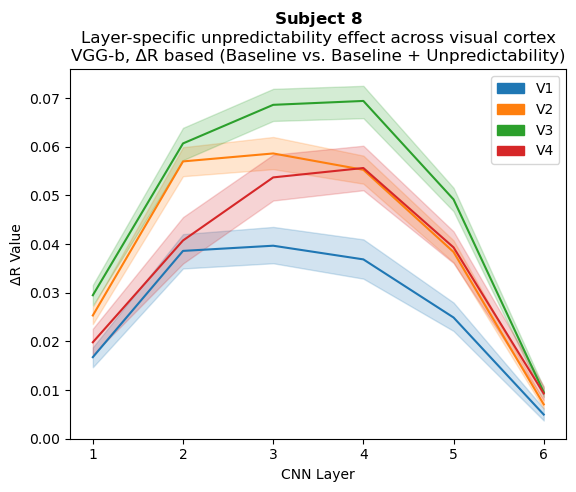

DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


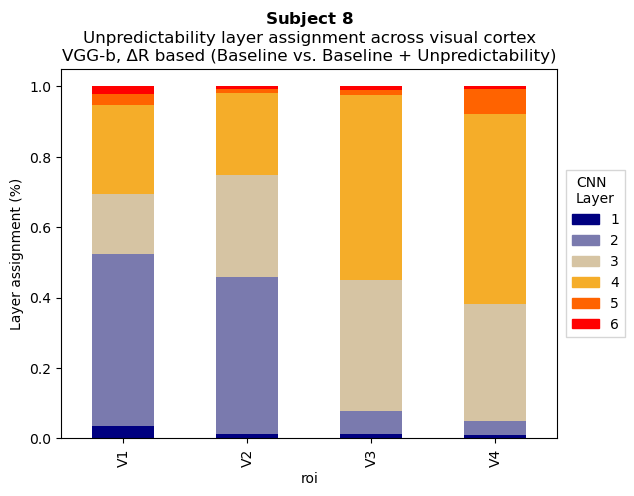

In [9]:
for subject in NSP.subjects:
    results = rd(subject = subject, folder="unpred", model="vgg-b", statistic="delta_r")
    results.mean_lines(
        fit_polynom=False, 
        polynom_order=2, 
        plot_catplot=False, 
        title=f"$\mathbf{{Subject\ {subject[-1]}}}$\nLayer-specific unpredictability effect across visual cortex\nVGG-b, ΔR based (Baseline vs. Baseline + Unpredictability)"
    )
    results._normalize_per_voxel()
    results.assign_layers(
        max_or_weighted="max", 
        title=f"$\mathbf{{Subject\ {subject[-1]}}}$\nUnpredictability layer assignment across visual cortex\nVGG-b, ΔR based (Baseline vs. Baseline + Unpredictability)"
    )

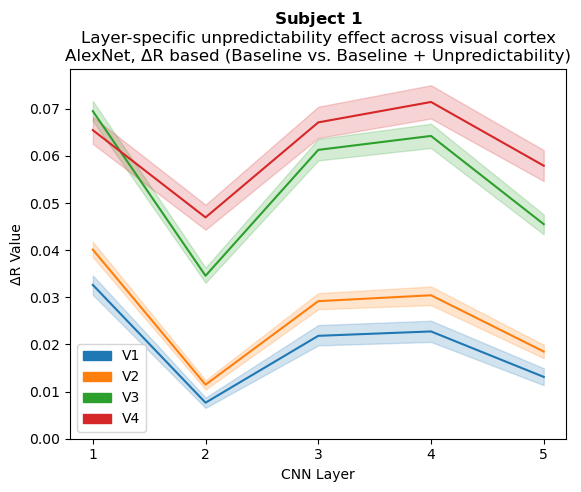

DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


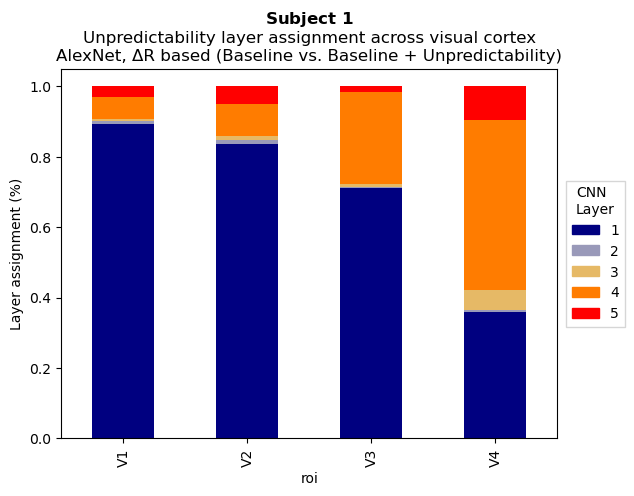

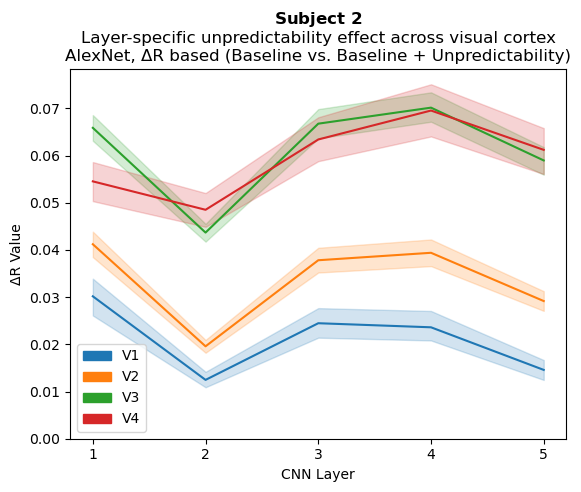

DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


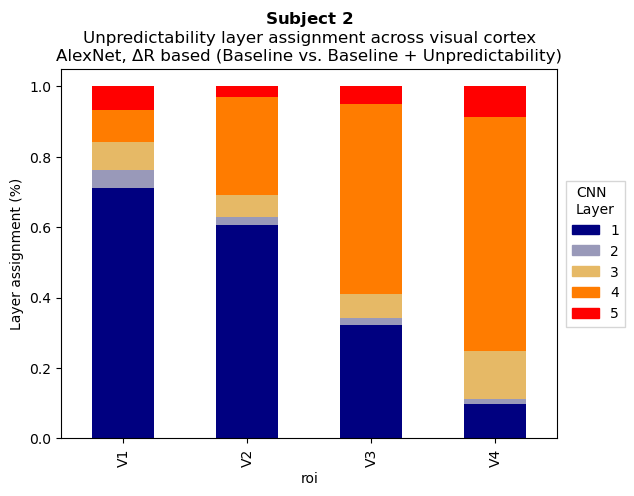

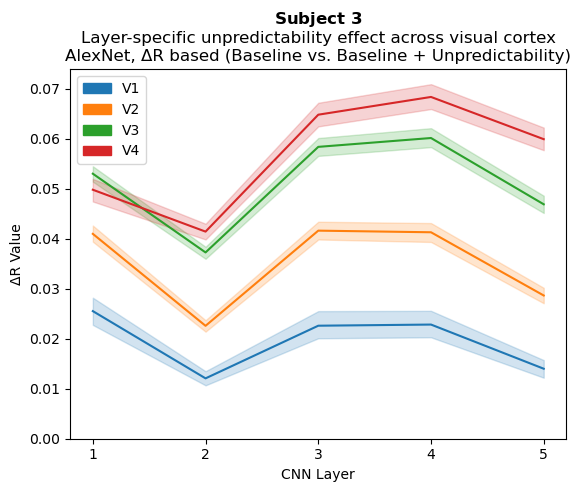

DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


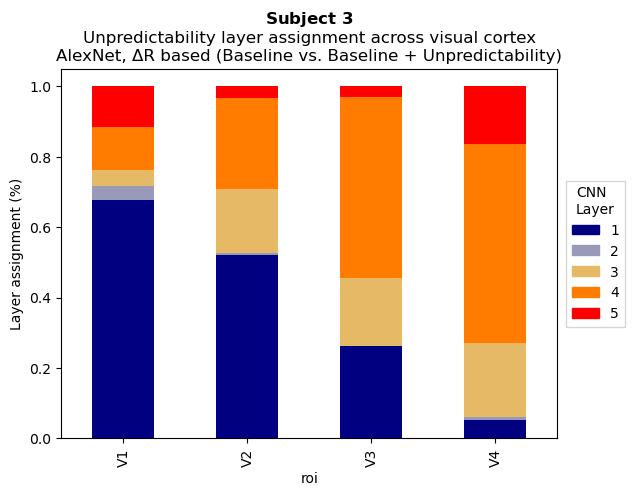

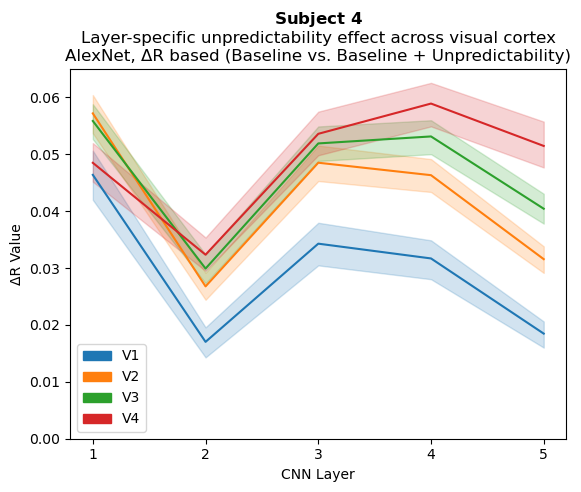

DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


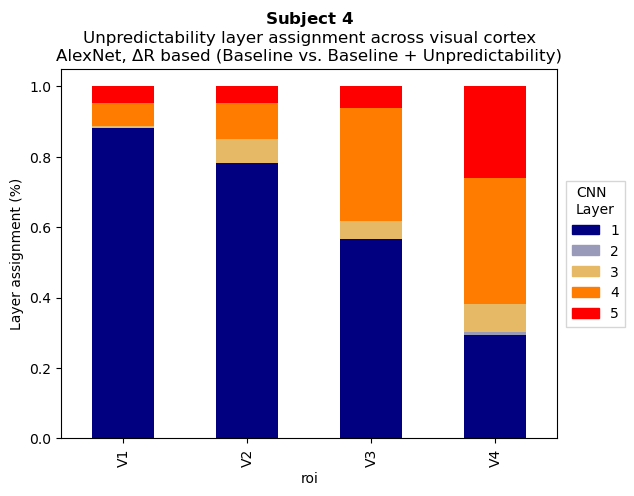

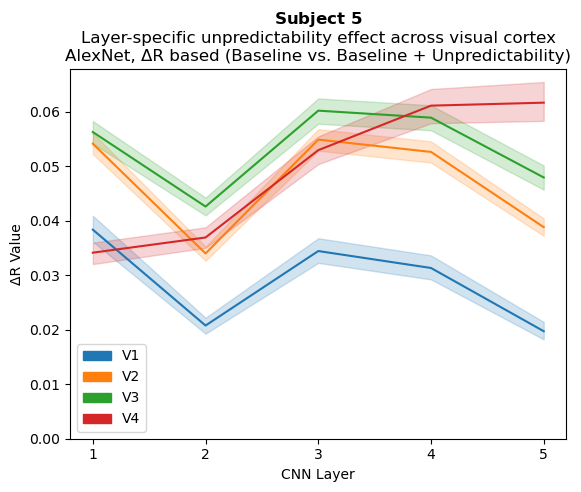

DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


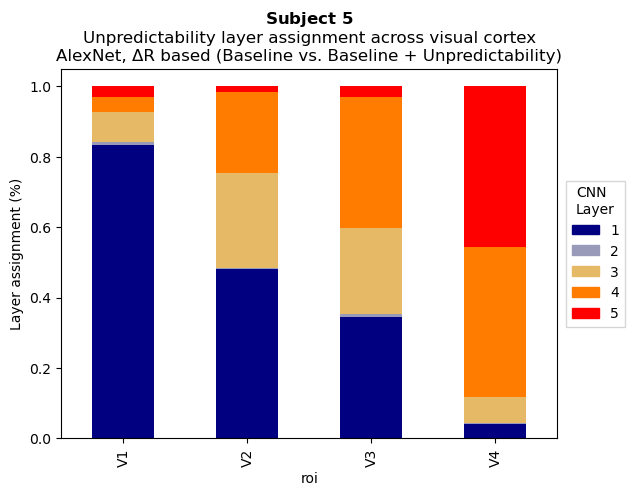

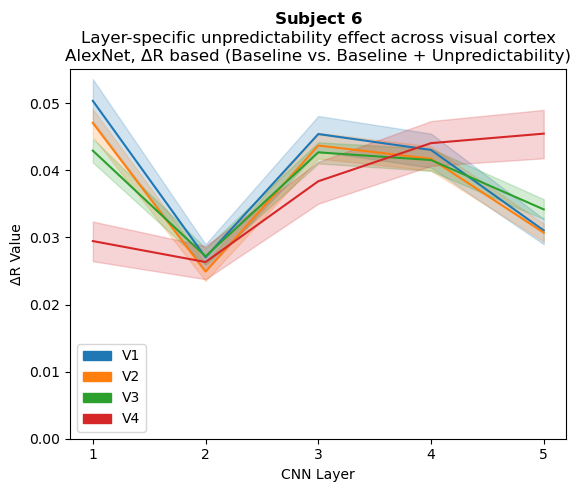

DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


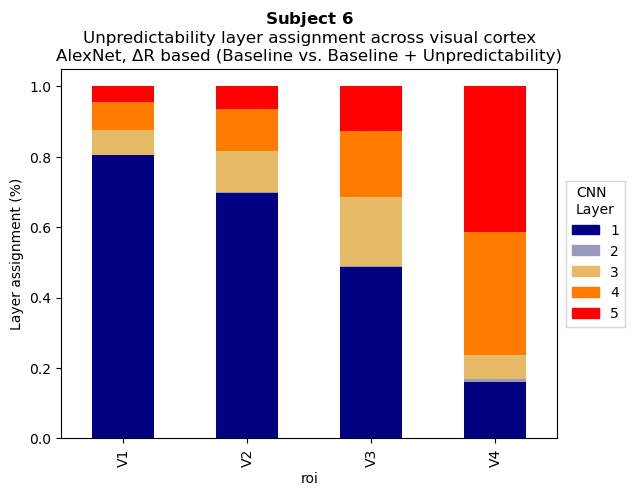

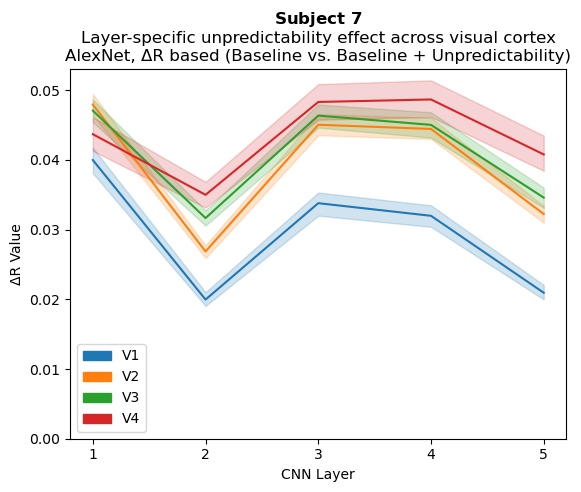

DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


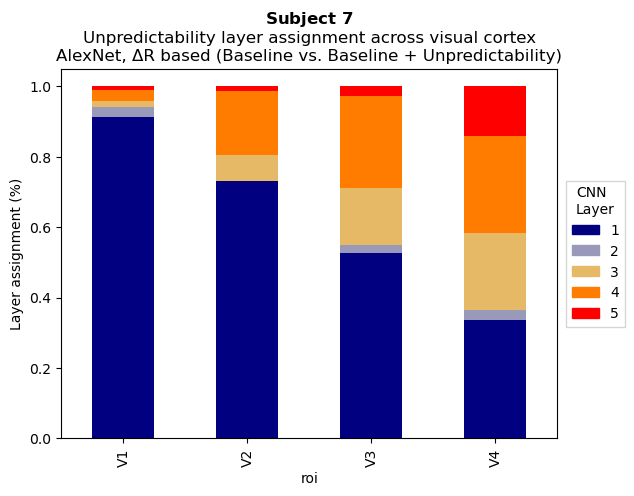

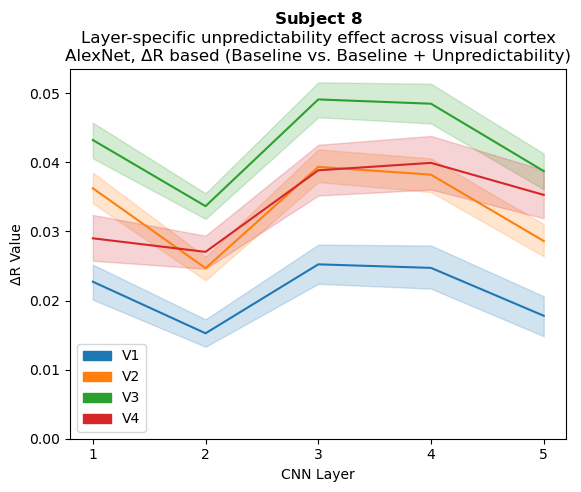

DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


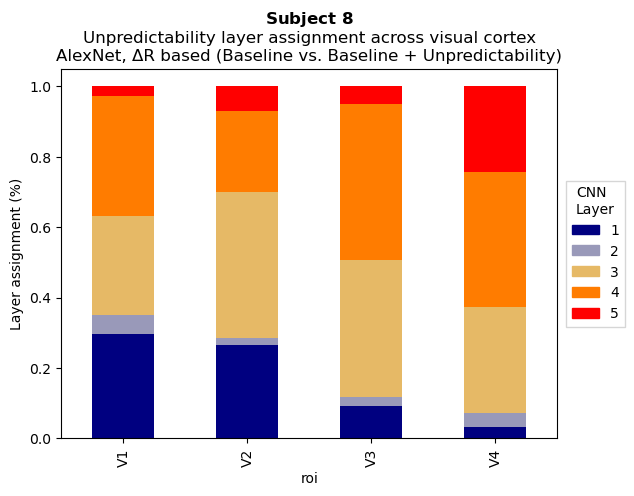

In [11]:
for subject in NSP.subjects:
    results = rd(subject = subject, folder="unpred", model="alexnet", statistic="delta_r")
    results.mean_lines(
        fit_polynom=False, 
        polynom_order=2, 
        plot_catplot=False, 
        title=f"$\mathbf{{Subject\ {subject[-1]}}}$\nLayer-specific unpredictability effect across visual cortex\nAlexNet, ΔR based (Baseline vs. Baseline + Unpredictability)"
    )
    results._normalize_per_voxel()
    results.assign_layers(
        max_or_weighted="max", 
        title=f"$\mathbf{{Subject\ {subject[-1]}}}$\nUnpredictability layer assignment across visual cortex\nAlexNet, ΔR based (Baseline vs. Baseline + Unpredictability)"
    )

Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


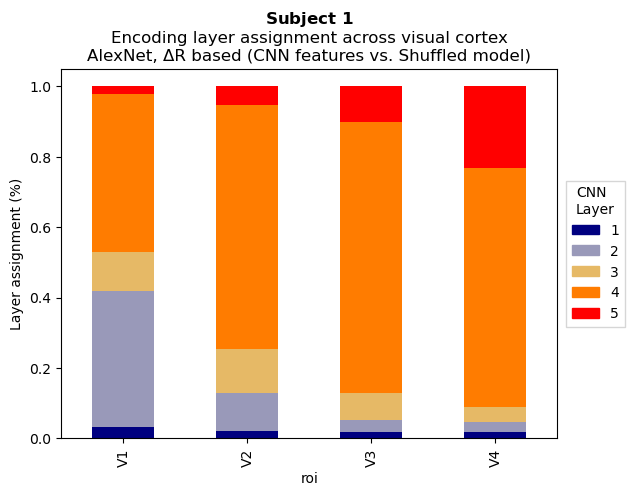

Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


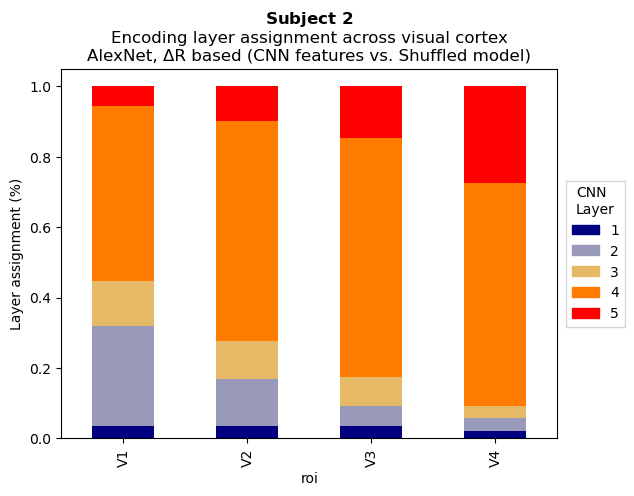

Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


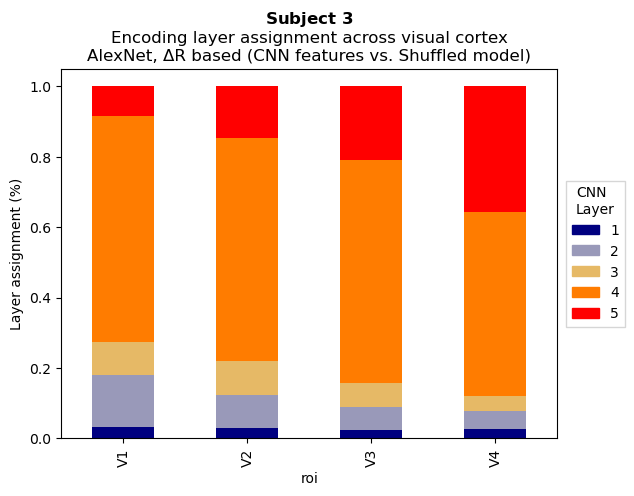

Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


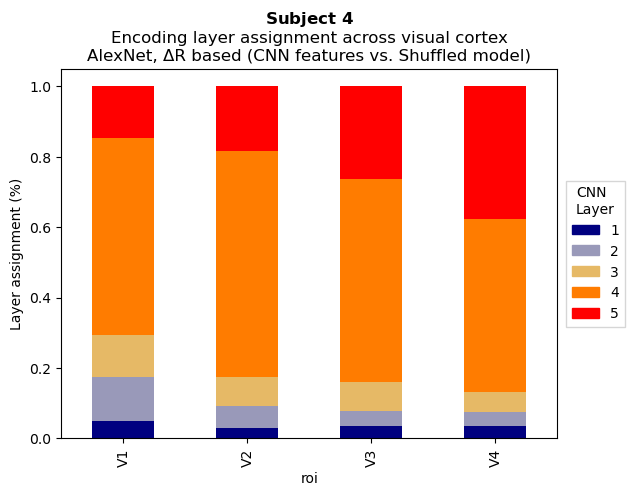

Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


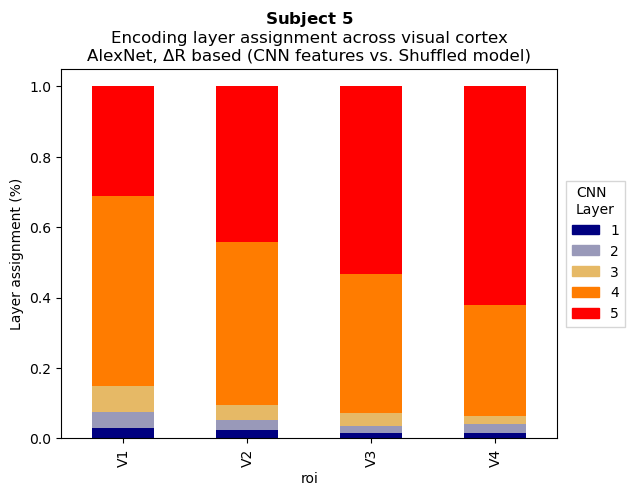

Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


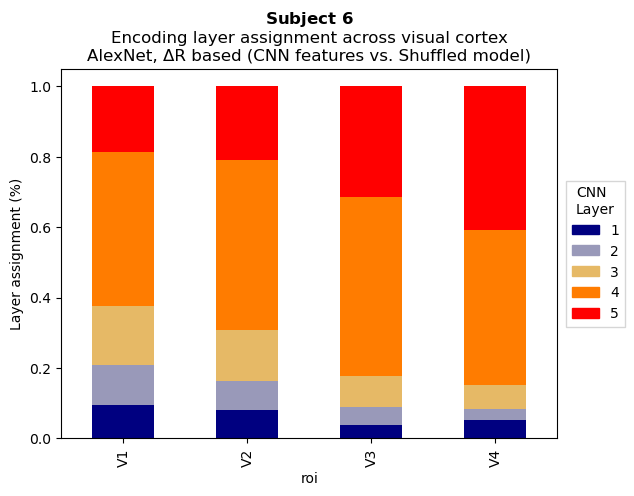

Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


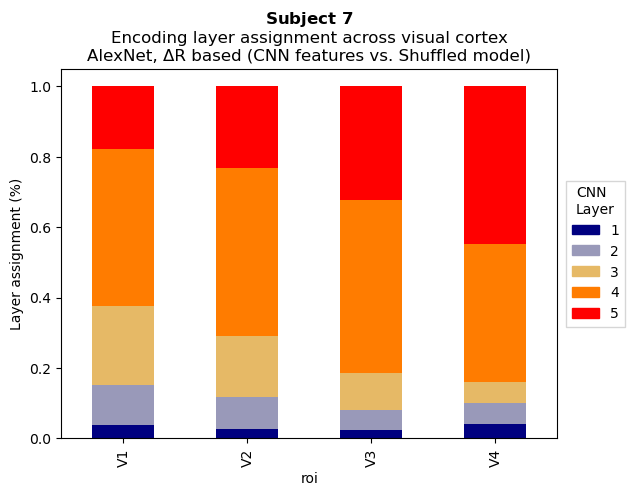

Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.


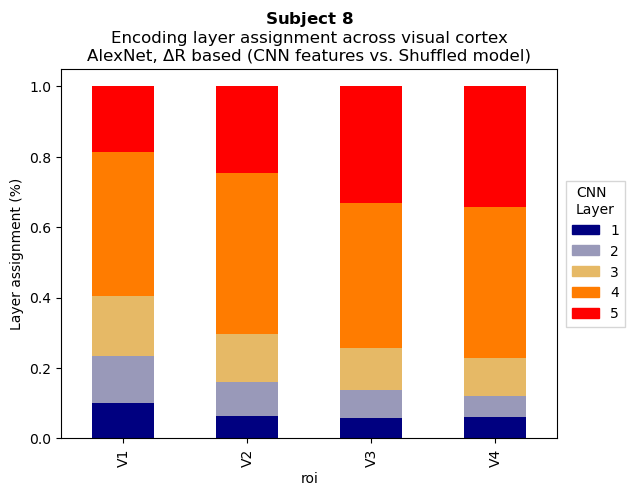

In [11]:
for subject in NSP.subjects:
    results = rd(subject = subject, folder="encoding", model="alexnet", statistic="delta_r")
    # results._normalize_per_voxel()
    results.assign_layers(
        max_or_weighted="max", 
        title=f"$\mathbf{{Subject\ {subject[-1]}}}$\nEncoding layer assignment across visual cortex\nAlexNet, ΔR based (CNN features vs. Shuffled model)"
    )